In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

In [18]:
# Establecemos un estilo visual agradable para los gráficos de Seaborn
sns.set(style="whitegrid")
print("Librerías importadas y estilo configurado.")

Librerías importadas y estilo configurado.


In [19]:
# --- 1. Carga y Revisión Inicial de Datos ---

try:
    df = pd.read_csv('../Data/Train.csv', index_col=0)
except FileNotFoundError:
    print("Error: Archivo no encontrado. Asegúrate de que 'tu_archivo.csv' esté en la ruta correcta.")

#--- Definimos la variable objetivo ---
TARGET_VAR = 'Reached.on.Time_Y.N'

# Verificamos que la variable objetivo exista
if TARGET_VAR not in df.columns:
    print(f"Error: La columna '{TARGET_VAR}' no se encuentra en el DataFrame.")
    # Detenemos la ejecución si el target no está
else:
    print(f"Variable objetivo (Target): {TARGET_VAR}")

    print("\n--- 1.1 Vistazo Inicial (Primeras 5 filas) ---")
    print(df.head())

    print("\n--- 1.2 Información General (Tipos de datos y Nulos) ---")
    # .info() es crucial para ver tipos de datos (dtypes) y conteo de nulos.
    df.info()
    # ANÁLISIS: Revisa si hay muchos valores nulos (Missing Values).
    # Revisa si las variables que crees numéricas son 'float' o 'int',
    # y las categóricas son 'object' o 'category'.

    print("\n--- 1.3 Descripción Estadística (Variables Numéricas) ---")
    # .describe() te da media, desviación estándar, mínimos, máximos y cuartiles.
    print(df.describe())
    # ANÁLISIS: Mira las escalas (min/max). ¿Hay variables con escalas muy diferentes?
    # ¿La media y la mediana (50%) son muy distintas? (Eso indica sesgo).

Variable objetivo (Target): Reached.on.Time_Y.N

--- 1.1 Vistazo Inicial (Primeras 5 filas) ---
   Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
ID                                                                          
1                D           Flight                    4                2   
2                F           Flight                    4                5   
3                A           Flight                    2                2   
4                B           Flight                    3                3   
5                C           Flight                    2                2   

    Cost_of_the_Product  Prior_purchases Product_importance Gender  \
ID                                                                   
1                   177                3                low      F   
2                   216                2                low      M   
3                   183                4                low      M   
4             

Descripción Estadística
Aquí es donde encontramos las pistas más profundas sobre el comportamiento de los datos.

<b>Reached.on.Time_Y.N (Target):</b>

min=0 y max=1: Confirma que es binario (0 y 1).

mean=0.596691: Esta es la pista más importante. Como los valores son 0 y 1, la media es igual al porcentaje de la clase "1".

Interpretación: El 59.7% de los envíos llegaron a tiempo (Clase 1), y el 40.3% no lo hicieron (Clase 0).

Conclusión: El dataset está muy bien balanceado. Esto es excelente para el modelado. No necesitamos preocuparnos por técnicas de remuestreo (como SMOTE) que se usan cuando una clase es muy rara (ej. 95% vs 5%). La métrica de "Accuracy" (Exactitud) será bastante fiable.

<b>Discount_offered (Descuento Ofrecido):</b>

mean=13.37 (Media)

50% (Mediana) = 7.00

Interpretación: La media (13.37) es casi el doble de la mediana (7). Esto nos dice que la mayoría de los descuentos son bajos (el 50% de los envíos tuvo un descuento de 7 o menos), pero hay unos pocos descuentos extremadamente altos (hasta 65) que están "tirando" de la media hacia arriba.

Conclusión: Esta variable está fuertemente sesgada hacia la derecha (right-skewed). En los gráficos bivariados, debemos tener esto en cuenta. Para modelos lineales, una transformación (como np.log()) podría ser necesaria.

<b>Weight_in_gms (Peso en Gramos):</b>

mean=3634 (Media)

50% (Mediana) = 4149

Interpretación: Aquí ocurre lo contrario. La media es menor que la mediana. Esto es menos común y sugiere una distribución extraña.

Hipótesis: Es probable que esta variable sea bimodal (tenga dos picos). Por ejemplo, quizás tienes un grupo de productos "ligeros" (1000-2000g) y otro grupo de productos "pesados" (4000-5000g), con pocos productos en el medio. El gráfico de densidad (KDE) que haremos luego es crucial para confirmar esto.

<b>Cost_of_the_Product (Costo):</b>

mean=210

50% (Mediana) = 214.

Interpretación: La media y la mediana están muy cerca. Esto sugiere que la distribución de los costos es bastante simétrica (como una "campana" normal). No hay valores atípicos (outliers) extremos.

<b>Otras variables (Rating, Calls, Purchases):</b>

Customer_rating: min=1, max=5. Es una escala de 1 a 5, como era de esperar. La media (2.99) es perfectamente central.

Customer_care_calls: min=2, max=7. Números discretos que parecen razonables.

Prior_purchases: min=2, max=10. La mayoría de los clientes (75%) tienen 4 o menos compras previas, pero algunos tienen hasta 10.

In [20]:
# --- 2. Preparación de Listas de Variables ---

# Separamos las variables para facilitar los gráficos
# (Excluimos el target de las 'features')

variables_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_VAR in variables_numericas:
    variables_numericas.remove(TARGET_VAR)

variables_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
if TARGET_VAR in variables_categoricas:
    variables_categoricas.remove(TARGET_VAR)

print(f"\nFeatures Numéricas identificadas: {variables_numericas}")
print(f"Features Categóricas identificadas: {variables_categoricas}")


Features Numéricas identificadas: ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
Features Categóricas identificadas: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']


Resumen de Hallazgos Clave

Problema: Clasificación binaria.

Calidad de Datos: Excelente. No hay valores nulos.

Target: Muy bien balanceado (59.7% vs 40.3%).

Variables a Vigilar (Candidatas a "Importantes"):

- Discount_offered: Muy sesgada. La mayoría son bajos, pero hay descuentos extremos.

- Weight_in_gms: Probablemente bimodal. Puede que haya dos "tipos" de envíos (ligeros/pesados).

Variables Categóricas: 
- Warehouse_block, Mode_of_Shipment, Product_importance, Gender están listas para ser analizadas.


--- 3.A ANÁLISIS BIVARIADO (TARGET CATEGÓRICO: Reached.on.Time_Y.N) ---
Analizando Features Numéricas vs Target...


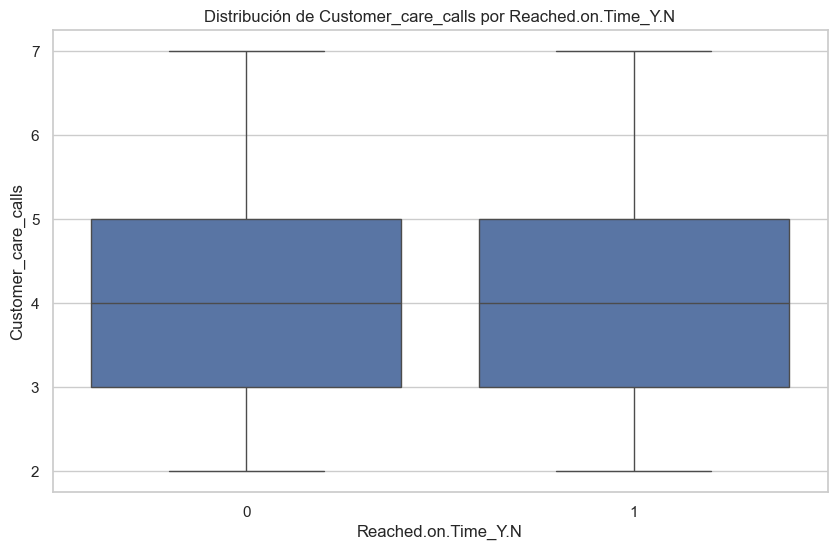

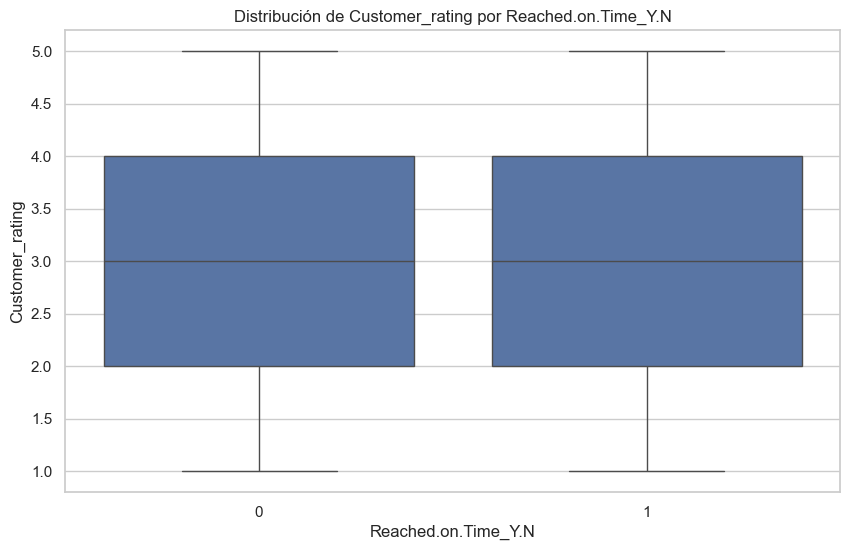

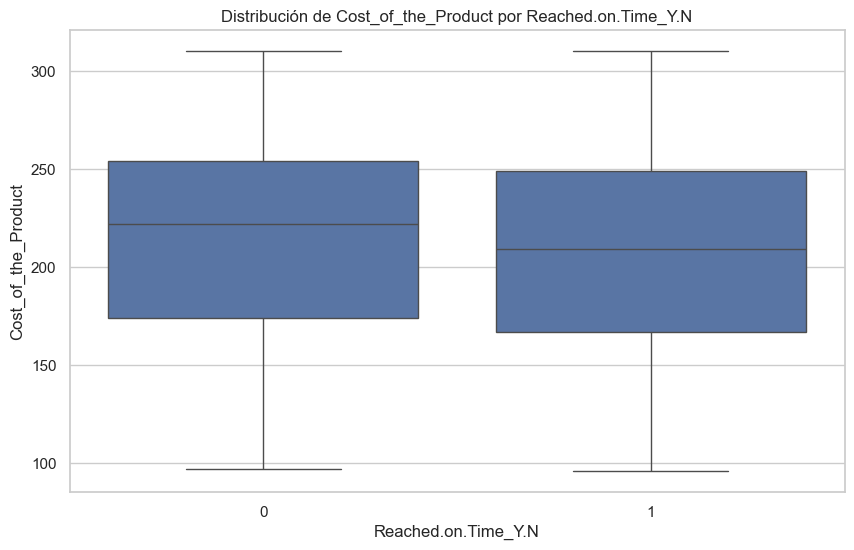

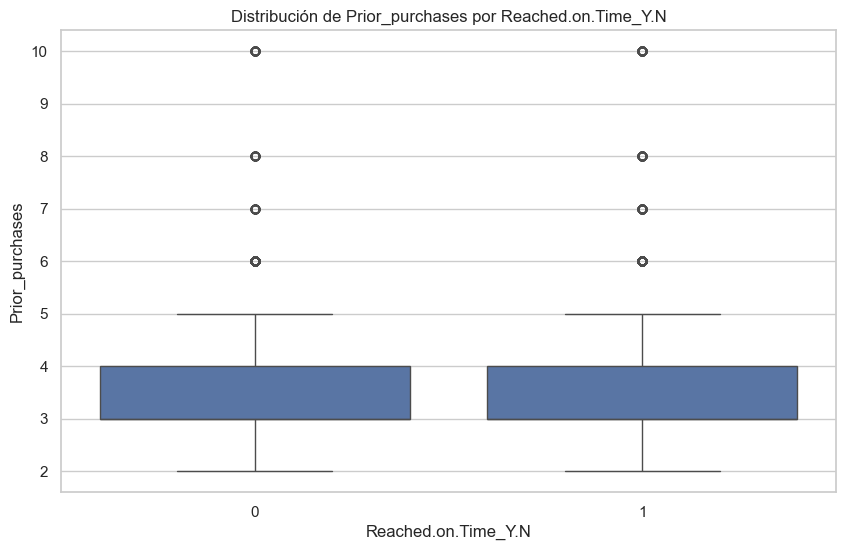

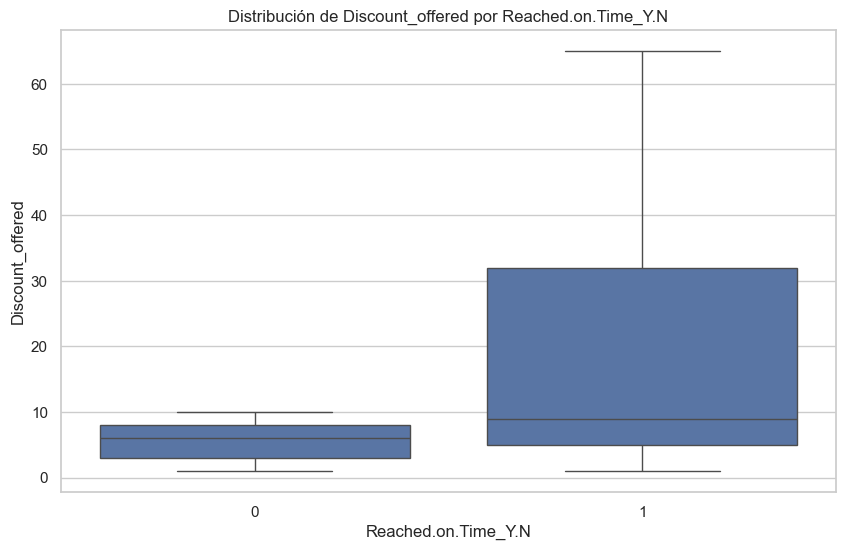

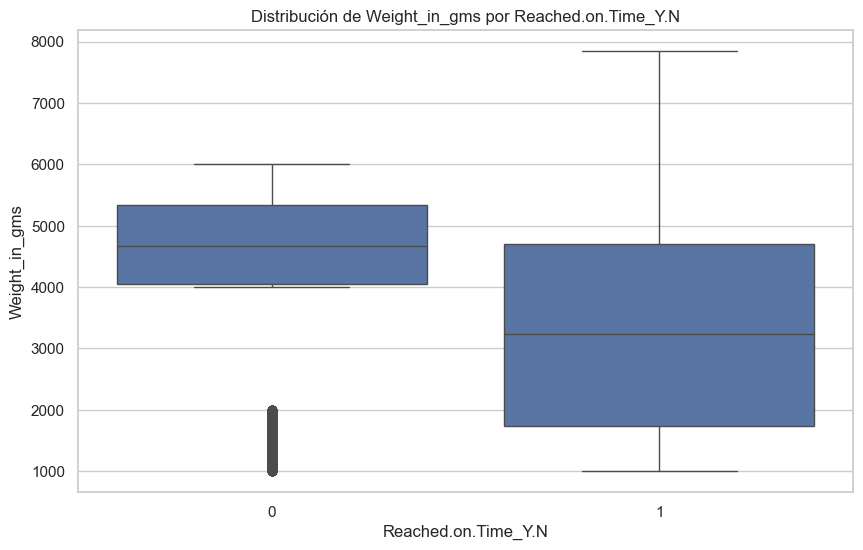

Analizando Features Categóricas vs Target...


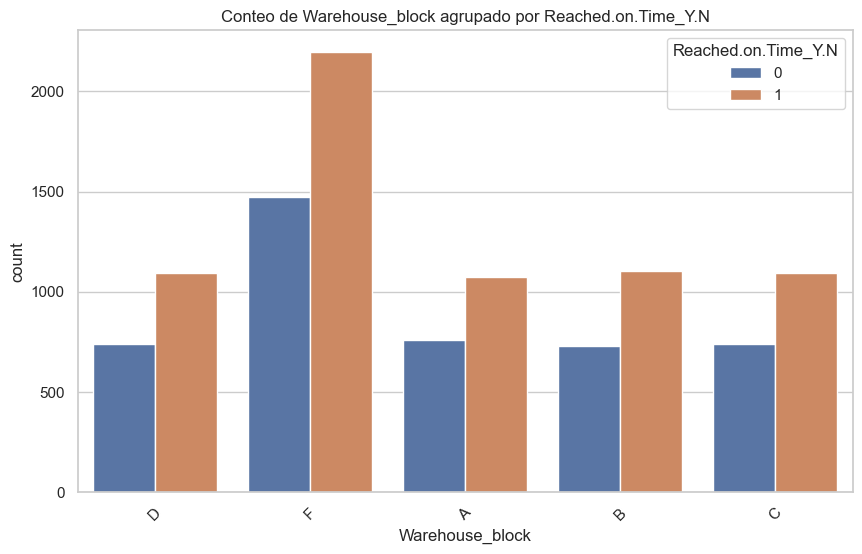

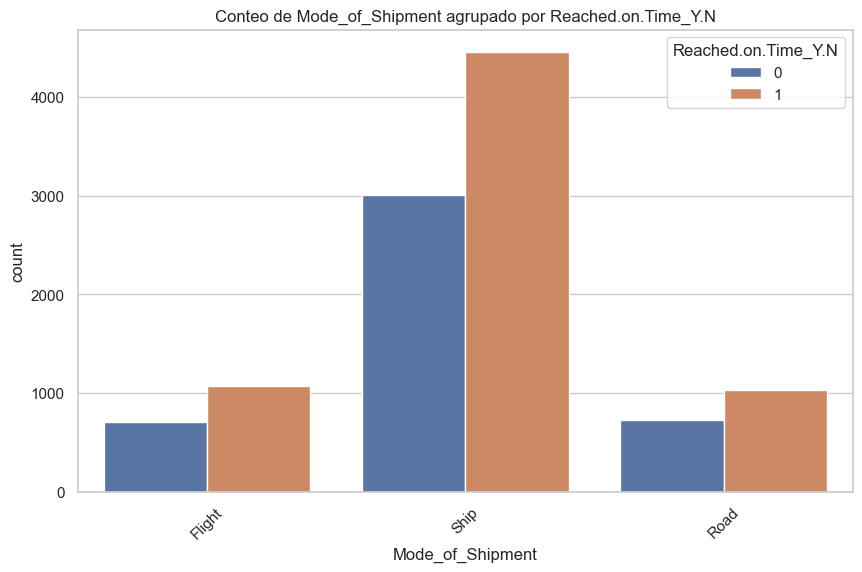

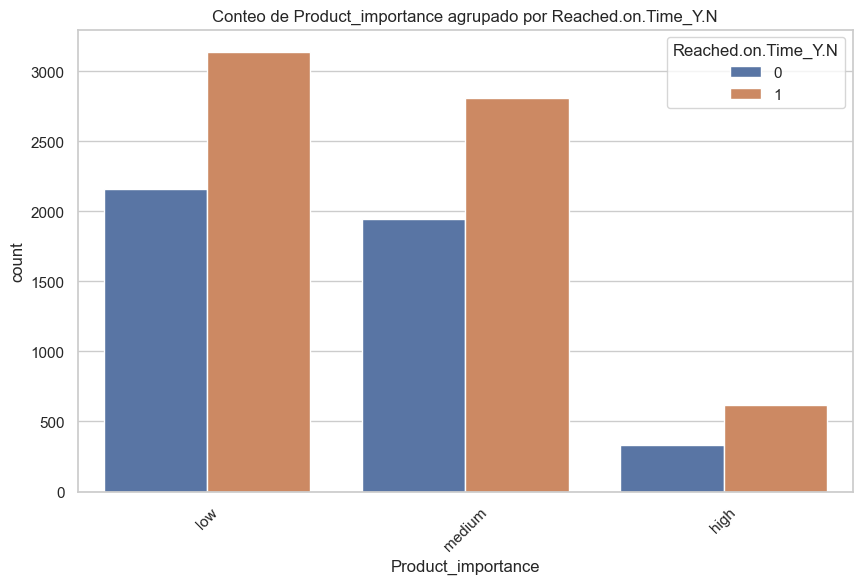

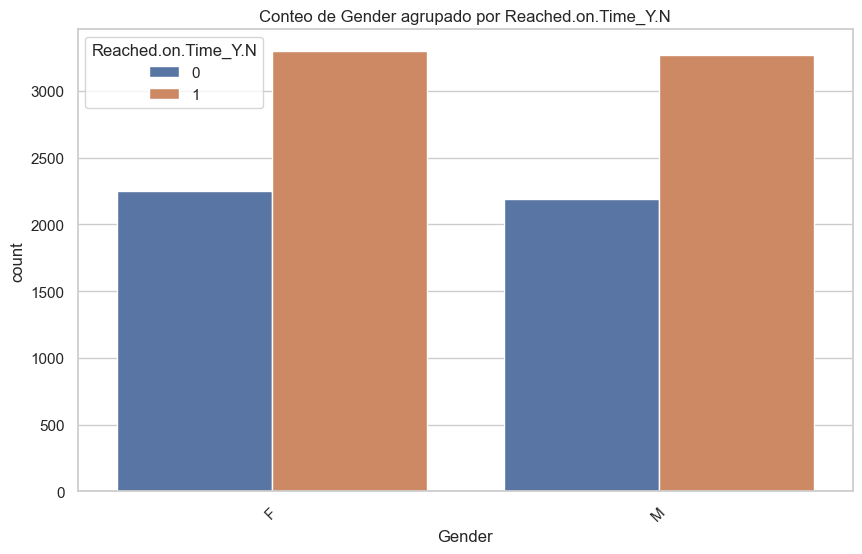

In [21]:
# --- 3. Análisis Bivariado (Relación de Features con el Target) ---

if df[TARGET_VAR].dtype == 'object' or df[TARGET_VAR].nunique() < 20:
    print(f"\n--- 3.A ANÁLISIS BIVARIADO (TARGET CATEGÓRICO: {TARGET_VAR}) ---")
    # Escenario 1: Target Categórico (Clasificación)

    # A. Features Numéricas vs. Target Categórico
    print("Analizando Features Numéricas vs Target...")
    for col in variables_numericas:
        plt.figure(figsize=(10, 6))
        # Boxplot (o Violinplot) es excelente para esto
        sns.boxplot(x=TARGET_VAR, y=col, data=df)
        plt.title(f'Distribución de {col} por {TARGET_VAR}')
        plt.show()


    # B. Features Categóricas vs. Target Categórico
    print("Analizando Features Categóricas vs Target...")
    for col in variables_categoricas:
        plt.figure(figsize=(10, 6))
        # Countplot con 'hue'
        sns.countplot(x=col, hue=TARGET_VAR, data=df, dodge=True)
        plt.title(f'Conteo de {col} agrupado por {TARGET_VAR}')
        plt.xticks(rotation=45)
        plt.show()
        # ANÁLISIS: Observa las proporciones. ¿Cambia la proporción de las clases
        # del target (ej. 0 vs 1) entre las diferentes categorías de la feature?
        # Si la Categoría 'A' es 90% 'Clase 1' y la 'B' es 10% 'Clase 1',
        # esa feature es muy informativa.

<b>Interpretación del Diagrama de Cajas (Discount_offered)</b>

Este gráfico compara la distribución de los descuentos ofrecidos para los envíos que no llegaron a tiempo (0) versus los que sí llegaron a tiempo (1).

1. Grupo "0" (No llegó a tiempo)
Observación: La caja es increíblemente pequeña y baja.

Mediana (línea central): Se sitúa alrededor de 5.

Caja (IQR): El 50% central de los datos está entre ~2 y ~8.

Bigote Superior: El valor máximo para este grupo parece estar en 10.

Interpretación: Los envíos que no llegaron a tiempo recibieron, casi exclusivamente, descuentos bajos (entre 0 y 10).

2. Grupo "1" (Sí llegó a tiempo)
Observación: La caja es enorme y mucho más alta.

Mediana (línea central): Es un poco más alta, quizás alrededor de 9.

Caja (IQR): El 50% central de los datos se extiende desde ~5 hasta ~32.

Bigote Superior: El bigote se extiende hasta el valor máximo que vimos en .describe() (alrededor de 65).

Interpretación: Este grupo contiene toda la variabilidad de los descuentos. Mientras que la mitad de este grupo también recibió descuentos bajos (por debajo de 9), la otra mitad (el cuartil superior) recibió descuentos significativos, desde 32 hasta 65.

<b>Conclusión y Significado para el Modelo</b>
Esta es una señal predictiva muy fuerte y, a la vez, una pregunta de negocio muy interesante. La variable Discount_offered es excelente para predecir el target. Un modelo de árbol de decisión aprenderá una regla muy simple y poderosa de esto.

Regla simple (Hipótesis)
- SI Discount_offered > 10, ENTONCES Reached.on.Time_Y.N = 1 (Casi siempre).
- SI Discount_offered <= 10, ENTONCES el resultado es mixto (aquí es donde otras variables tendrán que ayudar a decidir).

¿Por qué los envíos con altos descuentos llegan a tiempo?

- Hipótesis de Negocio 1: Los descuentos altos (ej. 50%, 65%) no son descuentos normales. Podrían ser "ofertas flash" o "ventas de liquidación" que se manejan a través de un sistema logístico diferente y más rápido para sacar el inventario.

- Hipótesis de Negocio 2: Los productos sin descuento (o con descuento bajo) son compras estándar que pasan por el sistema logístico normal, el cual tiene una tasa de falla del 40% (como vimos en el .describe()).

<b>Interpretación del Diagrama de Cajas (Weight_in_gms)</b>

Este gráfico compara la distribución del peso de los envíos que no llegaron a tiempo (0) versus los que sí llegaron a tiempo (1).

1. Grupo "0" (No llegó a tiempo)
Observación 1 (La Caja): La caja principal es muy estrecha y está muy alta. El 50% central de los envíos retrasados pesa entre ~4000g y ~5300g. La mediana (línea central) está alta, sobre los ~4600g.

Observación 2 (Los "Outliers"): Hay un enorme cluster de puntos entre ~1000g y ~2000g. El gráfico de cajas los marca como outliers, pero en realidad son un segundo grupo bien definido.

Interpretación: Los envíos que no llegan a tiempo parecen dividirse en dos categorías de productos muy claras:

El grupo principal de productos pesados (4000g - 6000g).

Un segundo grupo de productos ligeros (1000g - 2000g).

2. Grupo "1" (Sí llegó a tiempo)
Observación: La caja es enorme y cubre casi todo el rango. Va desde ~1700g hasta ~4700g, con bigotes que se extienden para cubrir casi todo el espectro de pesos (desde 1000g hasta más de 7000g).

Interpretación: Los envíos que sí llegan a tiempo tienen una distribución de peso mucho más "normal" y variada. Parece que el sistema logístico para los envíos "a tiempo" maneja todos los pesos de manera más consistente.

<b>Conclusión y Significado para el Modelo</b>

Esta variable es muy predictiva. Un modelo podrá aprender reglas claras de esto.

Los productos pesados (digamos > 4000g) tienen una alta probabilidad de retrasarse (pertenecen a la caja del grupo 0).

Los productos de peso medio (entre ~2000g y ~4000g) parecen llegar a tiempo con más frecuencia (son la parte baja de la caja del grupo 1).

Los productos ligeros (digamos < 2000g) son un misterio: pueden llegar a tiempo (parte de la caja del grupo 1) o pueden retrasarse (el cluster de outliers del grupo 0).


--- 4. Matriz de Correlación (Heatmap) ---


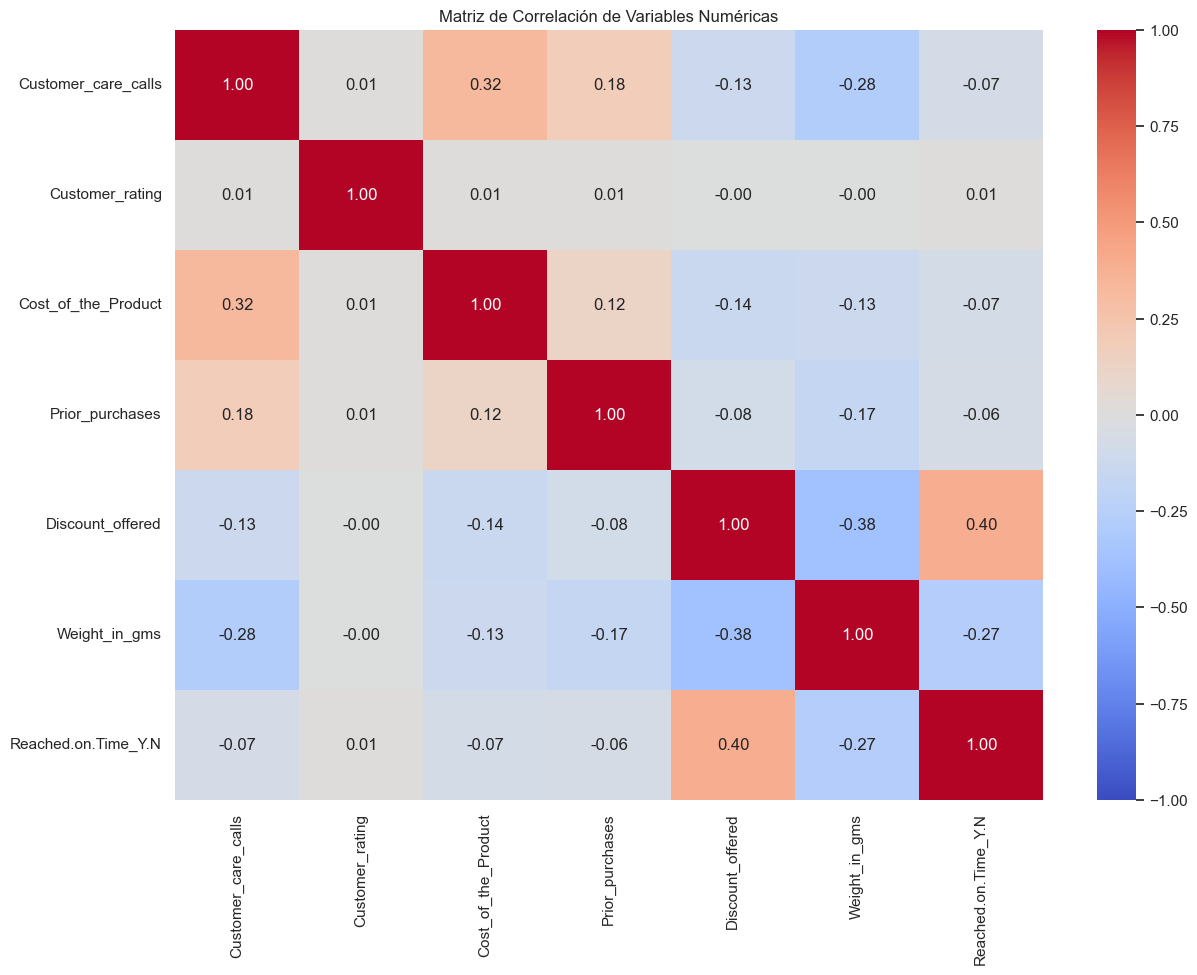

In [ ]:

# --- 4. Análisis Multivariado (Correlaciones entre Features) ---

print("\n--- 4. Matriz de Correlación (Heatmap) ---")

# Seleccionamos solo las variables numéricas (incluyendo el target si es numérico)
df_numerico = df.select_dtypes(include=[np.number])

# Calculamos la matriz de correlación (Método de Pearson)
corr_matrix = df_numerico.corr()

plt.figure(figsize=(14, 10))
# Usamos un heatmap para visualizar la matriz
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()


Relación de Features con el Target (Reached.on.Time_Y.N)

Discount_offered (0.40):

Es un valor positivo moderado. A medida que el Discount_offered aumenta, la probabilidad de que el paquete llegue a tiempo (Reached.on.Time_Y.N = 1) también aumenta linealmente. Esto confirma 100% lo que vimos en el gráfico de cajas.

Weight_in_gms (-0.27):

Es un valor negativo débil/moderado. Sugiere que, en general, a medida que el Weight_in_gms aumenta, la probabilidad de que llegue a tiempo disminuye (o, dicho de otra manera, aumenta la probabilidad de que se retrase).

Todas las demás variables (Customer_care_calls, Customer_rating, etc.):

Sus valores son extremadamente cercanos a 0 (-0.07, 0.01, -0.07, -0.06).

Estas variables no tienen ninguna relación lineal con el hecho de que un paquete llegue a tiempo.


--- 5. Pairplot (Vistazo rápido de relaciones) ---


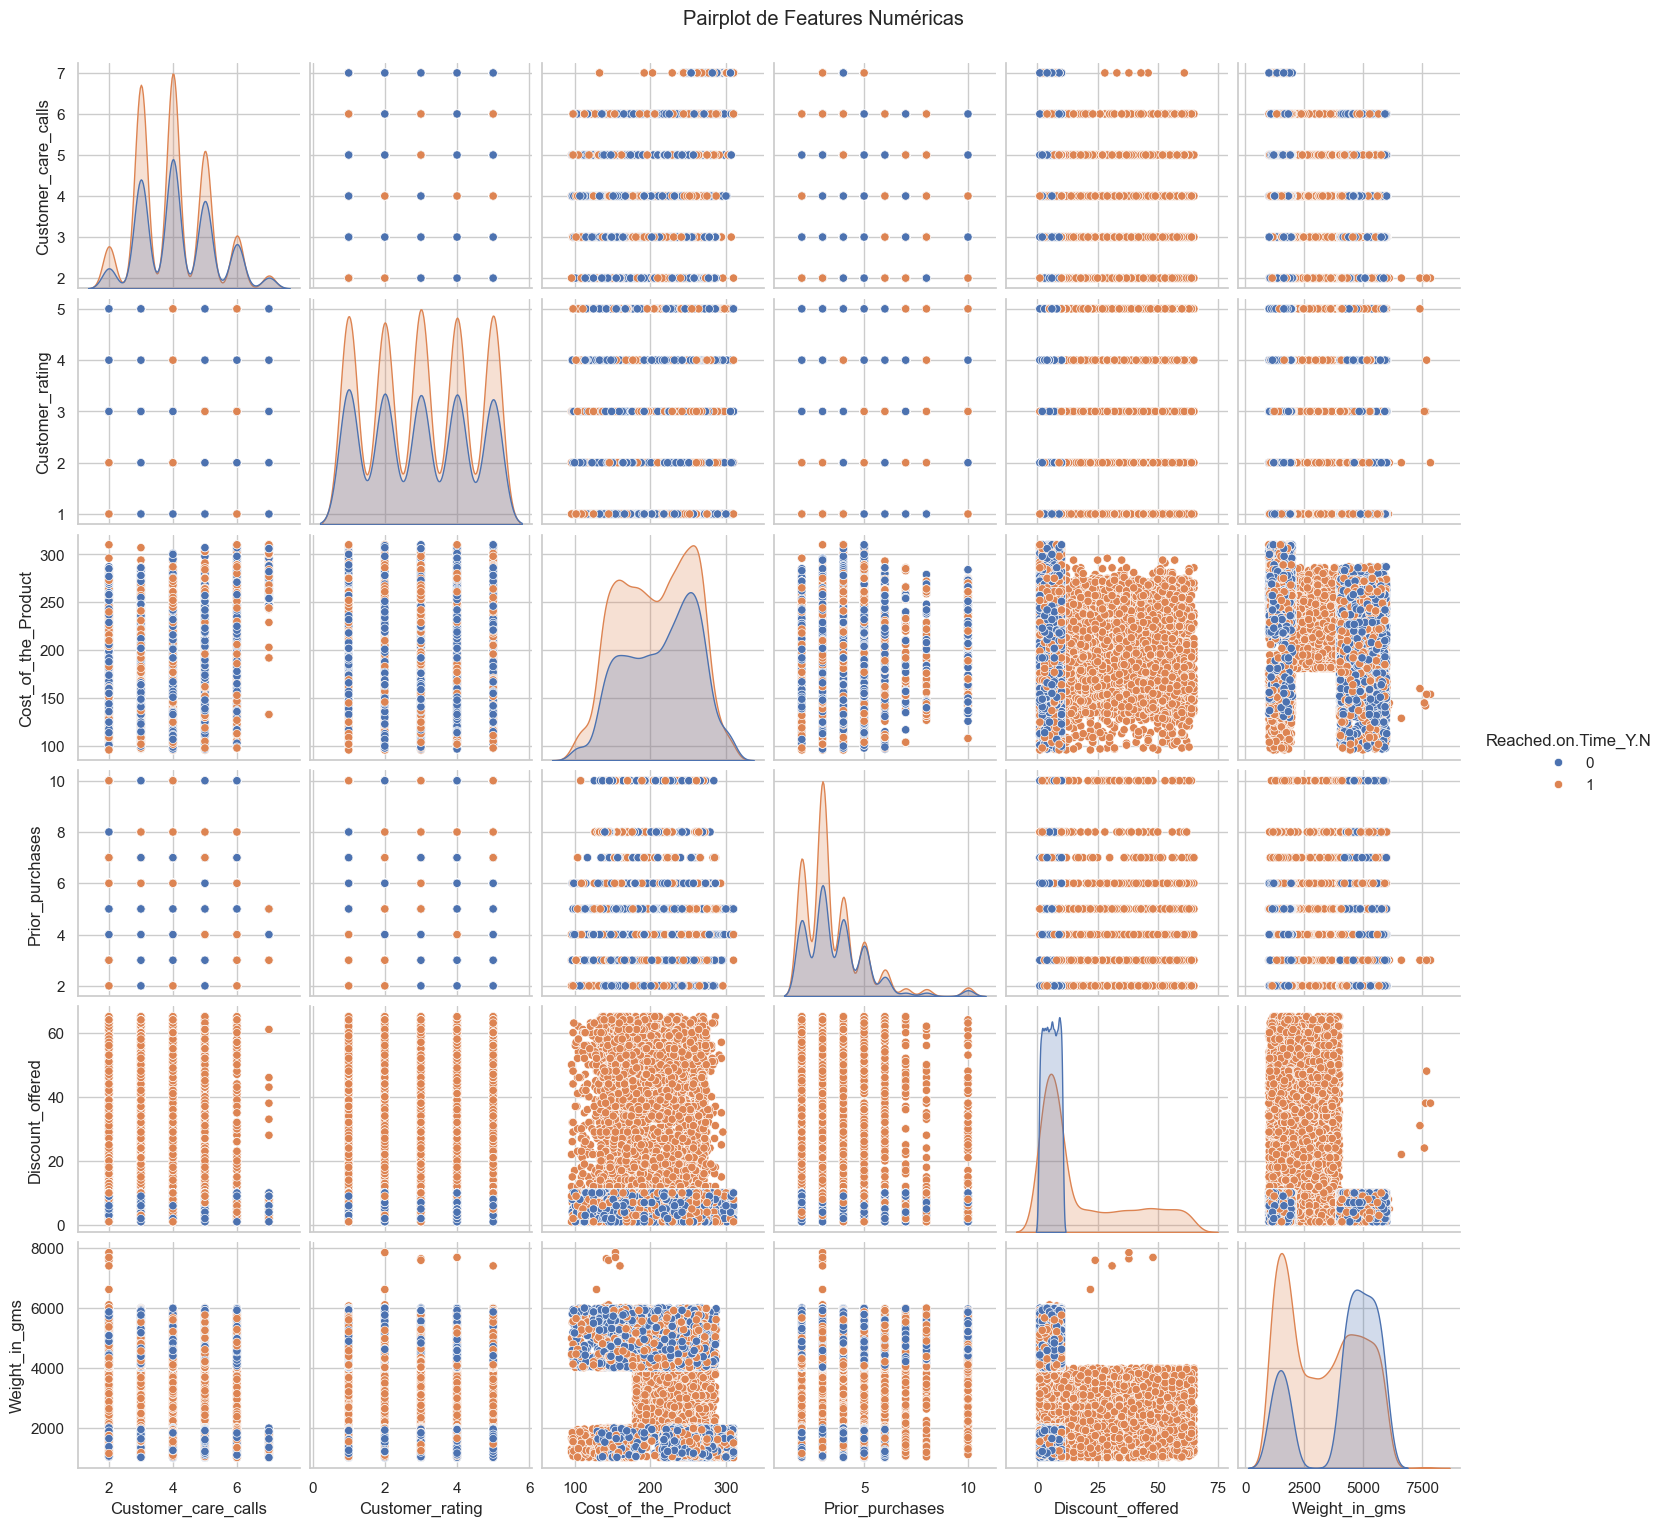


--- ¡Análisis EDA completado! ---


In [ ]:
# --- 5. Pairplot ---

if len(variables_numericas) > 0 and len(variables_numericas) <= 10:
    print("\n--- 5. Pairplot (Vistazo rápido de relaciones) ---")
    
    # Usamos 'hue' si el target es categórico para ver la separación de clases
    if df[TARGET_VAR].dtype == 'object' or df[TARGET_VAR].nunique() < 10:
        sns.pairplot(df, vars=variables_numericas, hue=TARGET_VAR)
    else:
        sns.pairplot(df, vars=variables_numericas)
        
    plt.suptitle('Pairplot de Features Numéricas', y=1.02)
    plt.show()
else:
    print("\n--- 5. Pairplot omitido (demasiadas variables numéricas para visualizar) ---")

print("\n--- ¡Análisis EDA completado! ---")

<b>Interpretación de la Diagonal (Gráficos KDE)</b>

La diagonal nos muestra la distribución de cada variable (como los gráficos de densidad superpuestos que discutimos) para la clase 0 (azul) y la clase 1 (naranja).

<b>Customer_care_calls, Customer_rating, Prior_purchases:</b>

- Las curvas azul y naranja están casi perfectamente superpuestas.

- Confirma lo que vimos en el heatmap. Estas variables no tienen poder predictivo por sí solas; su distribución es idéntica tanto si el paquete llega a tiempo como si no.

<b>Cost_of_the_Product:</b>

- Las curvas están muy superpuestas, aunque la curva azul (retrasado) parece ser ligeramente más alta en el rango de 200-275.

- Tiene un poder predictivo muy débil, casi nulo, por sí solo.

<b>Discount_offered</b>

- La curva azul (0, retrasado) es un pico agudo y alto solo en valores bajos (menos de 10). 
- La curva naranja (1, a tiempo) está mucho más extendida y cubre todo el rango de descuentos (de 0 a 65).
- Confirma al 100% el gráfico de cajas. Los retrasos casi solo ocurren con descuentos bajos. Si se ofrece un descuento alto, el envío casi siempre llega a tiempo.

<b>Weight_in_gms</b>

- La curva azul (0, retrasado) tiene DOS PICOS claros (es bimodal): un pico para productos ligeros (~1500g) y un pico más grande para productos pesados (~4500-5500g).
- La curva naranja (1, a tiempo) tiene un pico principal grande en el rango medio (~2000-4000g).
- Los envíos muy ligeros y los envíos pesados son los que sufren retrasos. Los envíos de peso medio tienden a llegar a tiempo.

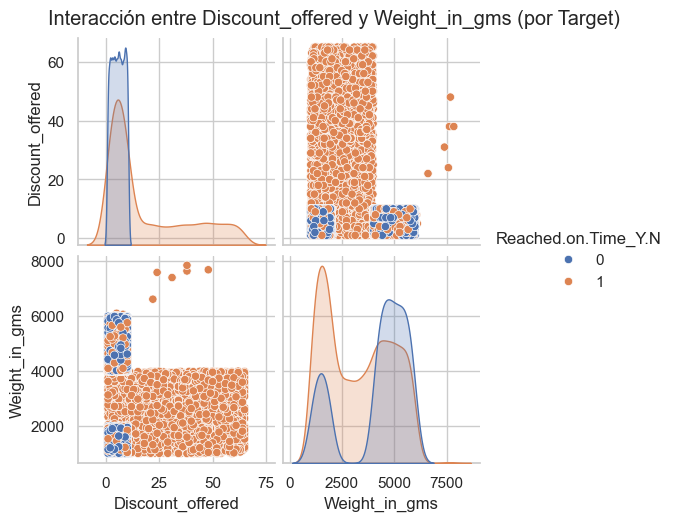

In [28]:
# --- Pairplot específico de las dos variables más correlacionadas con el target ---
variables_clave = ['Discount_offered', 'Weight_in_gms']

g = sns.pairplot(
    df,
    vars=variables_clave, 
    hue=TARGET_VAR,        # (Asumiendo que TARGET_VAR = 'Reached.on.Time_Y.N')
    diag_kind='kde'        # Mostramos KDE en la diagonal
)
g.fig.suptitle('Interacción entre Discount_offered y Weight_in_gms (por Target)', y=1.03)

plt.show()